A


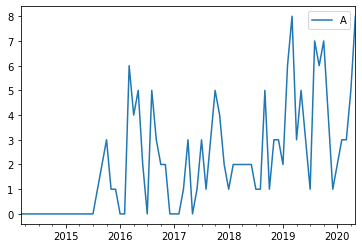

In [17]:
# Import Libraries
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Data import
df= pd.read_excel("C:\\Users\\HP\\Desktop\\Book1.xlsx")
input_ATA_NO=input()
data=df[[input_ATA_NO]]
data=data.head(75)

data=data.set_index(pd.date_range(start='2014-03-1', periods=75, freq='M'))
#data['Row Labels'] = pd.to_datetime(data["Row Labels"])
#data = data.set_index(['Row Labels'], drop=True)
data=data.head(75)
T_len=int(np.ceil(len(data)-6))
data.plot();

Min : 0
1% Quantile:  0.0
2% Quantile:  0.0
4% Quantile:  0.0
5% Quantile:  0.0
10% Quantile:  0.0
25% Quantile:  0.0
50% Quantile:  2.0
75% Quantile:  3.0
90% Quantile:  5.0
95% Quantile:  6.299999999999997
99% Quantile:  8.0
Max:  8
Mean:  2.12
Median:  2.0


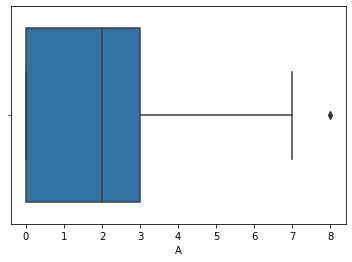

In [18]:





#Data Summary
print("Min :",data[input_ATA_NO].min())
print("1% Quantile: ",data[input_ATA_NO].quantile(0.01))
print("2% Quantile: ",data[input_ATA_NO].quantile(0.02))
print("4% Quantile: ",data[input_ATA_NO].quantile(0.03))
print("5% Quantile: ",data[input_ATA_NO].quantile(0.05))
print("10% Quantile: ",data[input_ATA_NO].quantile(0.10))
print("25% Quantile: ",data[input_ATA_NO].quantile(0.25))
print("50% Quantile: ",data[input_ATA_NO].quantile(0.50))
print("75% Quantile: ",data[input_ATA_NO].quantile(0.75))
print("90% Quantile: ",data[input_ATA_NO].quantile(0.90))
print("95% Quantile: ",data[input_ATA_NO].quantile(0.95))
print("99% Quantile: ",data[input_ATA_NO].quantile(0.99))
print("Max: ",data[input_ATA_NO].max())
print("Mean: ",data[input_ATA_NO].mean())
print("Median: ",data[input_ATA_NO].median())
#print("Mode: ",data[input_ATA_NO].mode())
sns.boxplot(data[input_ATA_NO])

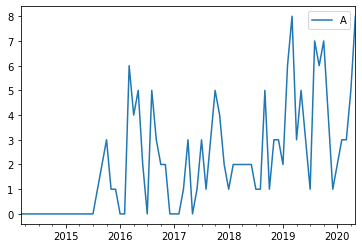

In [19]:
data[input_ATA_NO]=data[input_ATA_NO].clip(upper=data[input_ATA_NO].quantile(0.99))#.clip_lower(data[input_ATA_NO].quantile(0.02))
data.plot()

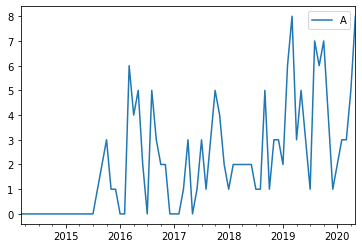

In [20]:
data_ewm=data#.ewm(span=12).mean()
data_ewm.plot()

### train-test split

In [21]:
train=data_ewm[0:T_len]
test=data_ewm[T_len:]
print(len(train))
print(len(test))

69
6


In [22]:
test

,A
2019-12-31,1
2020-01-31,2
2020-02-29,3
2020-03-31,3
2020-04-30,5
2020-05-31,8


In [23]:
import warnings
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [24]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
Aic=[]
odr=[]
sodr=[]
tr_rmse=[]
te_rmse=[]
ape=[]
Act=[]
Forecast1=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(disp=-1)
            predicted=results.fittedvalues
            train_rmse=sqrt(mean_squared_error(train, predicted))
            test_rmse=sqrt(mean_squared_error(test,results.forecast(len(test))))
            #mape=1-(np.abs(test[input_ATA_NO]-results.forecast(len(test)))/test[input_ATA_NO]).mean()
            
            # Use for for 6 mon.,12 mon.,18 mon,
            mape=1-(np.abs((test[input_ATA_NO]).sum()-(results.forecast(len(test)).sum()))/test[input_ATA_NO].sum()) 
            
            
            Aic.append(results.aic)
            Act.append(test[input_ATA_NO].sum())
            Forecast1.append(results.forecast(len(test)).tail(6).sum())
            odr.append(param)
            sodr.append(param_seasonal)
            tr_rmse.append(train_rmse)
            te_rmse.append(test_rmse)
            ape.append(mape)
        except:
            continue
fore=pd.DataFrame.from_dict({"AIC":Aic,"order":odr,"seasonal_order":sodr,"train_rmse":tr_rmse,"test_rmse":te_rmse,"MAPE_6":ape,"Act":Act,"Forecast1":Forecast1})
fore["abs_diff"]=np.abs(fore["train_rmse"]-fore["test_rmse"])

In [25]:
dd=pd.DataFrame(fore.sort_values(by=['test_rmse'],ascending=True)).head(30)
#dd=dd.sort_values(by=['abs_diff'],ascending=True)
dd

,AIC,order,seasonal_order,train_rmse,test_rmse,MAPE_6,Act,Forecast1,abs_diff
79,195.547579,"(1, 1, 0)","(1, 1, 1, 12)",1.859034,1.877185,0.995008,22,21.890174,0.018151
43,185.652542,"(0, 1, 1)","(1, 1, 1, 12)",1.766654,1.894598,0.944160,22,23.228483,0.127944
91,187.541941,"(1, 1, 1)","(1, 1, 1, 12)",1.761693,1.907166,0.931422,22,23.508716,0.145474
31,205.675832,"(0, 1, 0)","(1, 1, 1, 12)",2.080355,1.920949,0.842329,22,18.531233,0.159406
27,203.003746,"(0, 1, 0)","(0, 1, 1, 12)",2.087594,1.970430,0.912121,22,23.933333,0.117165
139,186.178982,"(2, 1, 1)","(1, 1, 1, 12)",1.707437,1.997316,0.954224,22,20.992918,0.289880
127,185.284675,"(2, 1, 0)","(1, 1, 1, 12)",1.719200,2.008795,0.915405,22,23.861094,0.289596
9,210.446613,"(0, 0, 0)","(2, 0, 1, 12)",1.941722,2.038951,0.861512,22,18.953266,0.097229
21,209.995564,"(0, 0, 1)","(2, 0, 1, 12)",1.883002,2.126597,0.760864,22,16.739009,0.243595
131,129.546463,"(2, 1, 0)","(2, 1, 1, 12)",1.641127,2.138854,0.888169,22,24.460286,0.497727


In [31]:
param_order =(0,1,1)
param_seasonal_order =(1,1,1, 12)
model = sm.tsa.statespace.SARIMAX(train,
                                      order=param_order,#dd.iloc[0]['order'],
                                      seasonal_order=param_seasonal_order,#dd.iloc[0]['seasonal_order'],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
results = model.fit()
#number_of_month=input('number_of_month')
print("Sum of {} month forecasting ".format(results.forecast(6).tail(6).sum()))
df2=pd.DataFrame(results.forecast(6))
df2

Sum of 23.2284833567523 month forecasting 


,0
2019-12-31,3.455259
2020-01-31,2.936251
2020-02-29,2.453874
2020-03-31,4.290725
2020-04-30,5.600545
2020-05-31,4.491829


In [32]:

#param_order =(1, 1, 0)
#param_seasonal_order =(0, 0, 0, 12)

model = sm.tsa.statespace.SARIMAX(data,
                                      order=param_order,#dd.iloc[0]['order'],
                                      seasonal_order=param_seasonal_order,#dd.iloc[0]['seasonal_order'],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
results = model.fit()
#number_of_month=input('number_of_month')
print("Sum of {} month forecasting ".format(results.forecast(12).tail(12).sum()))
df2=pd.DataFrame(results.forecast(12))#.tail(12))
df2


Sum of 69.17583312192086 month forecasting 


,0
2020-06-30,4.904436
2020-07-31,5.131752
2020-08-31,4.741738
2020-09-30,6.460965
2020-10-31,5.617509
2020-11-30,6.104429
2020-12-31,5.715590
2021-01-31,4.580211
2021-02-28,5.780200
2021-03-31,8.207446


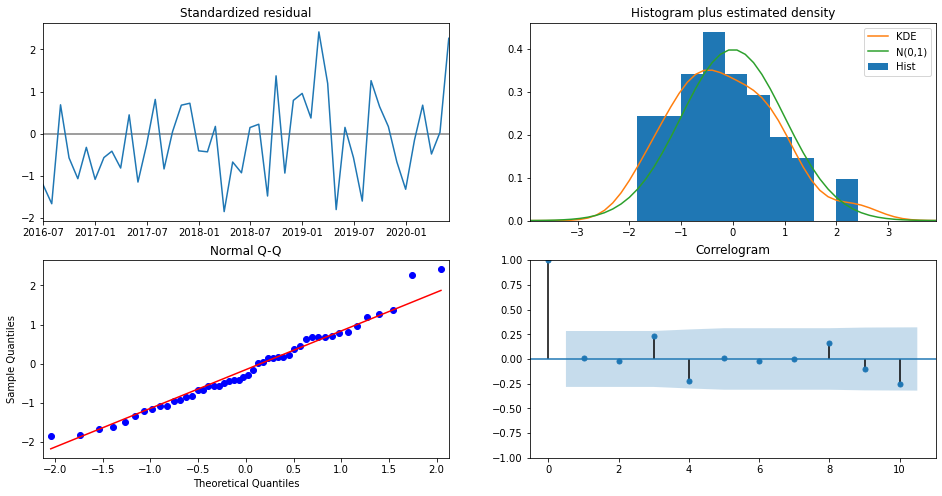

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

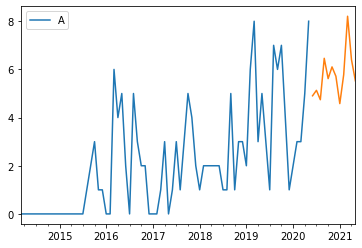

In [34]:
fore = results.forecast(12)
#data1.plot(figsize=(15, 6))
data.plot()
#test.plot()
fore.plot()#(figsize=(15, 6))
#test.plot()

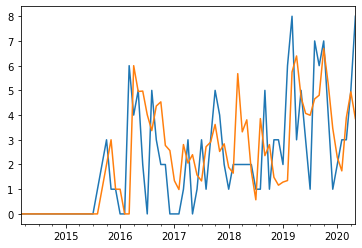

In [35]:
data[input_ATA_NO].plot()
results.fittedvalues.plot()